In [11]:
from sql.future_data_manager import FuturesDataManager
from custom_indicators.force_indicator import ForceIndex
import backtrader as bt
%matplotlib inline

In [35]:
fdm = FuturesDataManager()
data_df = fdm.query_data(symbol='M0', start_date='2024-01-01', end_date='2025-12-31')
data_df.head()

,id,symbol,exchange,name,date,open,high,low,close,volume,open_interest,settlement_price,data_type,created_time,updated_time
0,2458,M0,dce,豆粕连续,2024-12-31,2689.0,2713.0,2682.0,2696.0,1501390,2366120,2696.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08
1,2457,M0,dce,豆粕连续,2024-12-30,2671.0,2687.0,2662.0,2683.0,1237240,2442770,2675.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08
2,2456,M0,dce,豆粕连续,2024-12-27,2672.0,2698.0,2665.0,2670.0,1528419,2467545,2679.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08
3,2455,M0,dce,豆粕连续,2024-12-26,2638.0,2672.0,2624.0,2668.0,1272960,2511561,2649.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08
4,2454,M0,dce,豆粕连续,2024-12-25,2630.0,2649.0,2615.0,2645.0,1116068,2557221,2631.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08


In [4]:
class TestStrategy(bt.Strategy):
    def __init__(self):
        self.force_index = ForceIndex(self.data)

In [27]:
import pandas as pd


def plot_force_index_simple(df):
    """简化版本的绘图函数，避免版本兼容性问题"""
    
    # 创建Cerebro引擎
    cerebro = bt.Cerebro()
    
    # 添加策略
    cerebro.addstrategy(TestStrategy)
    
    # 准备数据 - 确保日期格式正确
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.sort_index()  # 按时间排序
    
    data = bt.feeds.PandasData(
        dataname=df,
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None
    )
    
    # 添加数据到Cerebro
    cerebro.adddata(data)
    
    # 设置初始资金
    cerebro.broker.setcash(100000.0)
    
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    print('开始回测...')
    
    # 运行回测
    results = cerebro.run()
    
    # 绘制图表 - 使用更兼容的方式
    print('绘制3333图表...')
    # cerebro.plot(style='candle', volume=False, iplot=False)
    
    return results

# 如果您已经有DataFrame，使用这个函数
def plot_with_existing_data(df):
    """使用现有DataFrame数据绘图的主函数"""
    
    print("数据预览:")
    print(df.head())
    print(f"\n数据形状: {df.shape}")
    
    # 检查必要的列是否存在
    required_cols = ['date', 'open', 'high', 'low', 'close', 'volume']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"缺少必要的列: {missing_cols}")
        return
    
    try:
        # 方法2: 绘制图表
        print("\n绘制图表...")
        plot_force_index_simple(df)
        
    except Exception as e:
        print(f"发生错误: {e}")
        print("尝试替代方法...")

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_manual_force_index(df):
    """手动计算并绘制强力指标"""
    
    # 准备数据
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # 计算强力指标
    df['price_change'] = df['close'] - df['close'].shift(1)
    df['log_volume'] = np.log1p(df['volume'])
    df['raw_force'] = df['price_change'] * df['log_volume']
    df['force_index'] = df['raw_force'].ewm(span=2).mean()
    
    # 创建图表
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # 1. K线图（简化版）
    ax1.plot(df['date'], df['close'], label='Close Price', color='black', linewidth=2)
    ax1.fill_between(df['date'], df['low'], df['high'], alpha=0.3, color='gray')
    ax1.set_title('Price Chart')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # 2. 成交量
    ax2.bar(df['date'], df['volume'], color='blue', alpha=0.7, label='Volume')
    ax2.set_ylabel('Volume')
    ax2.legend()
    ax2.grid(True)
    
    # 3. 强力指标
    ax3.plot(df['date'], df['force_index'], label='Force Index', color='red', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_ylabel('Force Index')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印指标值
    print("强力指标数值:")
    for i, row in df.iterrows():
        if not pd.isna(row['force_index']):
            print(f"{row['date'].strftime('%Y-%m-%d')}: {row['force_index']:.2f}")
    
    return df


In [31]:
plot_with_existing_data(df=data_df)

数据预览:
       id symbol exchange  name        date    open    high     low   close  \
0  222249     M0      dce  豆粕连续  2025-10-20  2868.0  2910.0  2866.0  2895.0   
1  177185     M0      dce  豆粕连续  2025-10-17  2910.0  2914.0  2863.0  2868.0   
2  177184     M0      dce  豆粕连续  2025-10-16  2913.0  2925.0  2906.0  2907.0   
3  177183     M0      dce  豆粕连续  2025-10-15  2902.0  2930.0  2897.0  2917.0   
4  177182     M0      dce  豆粕连续  2025-10-14  2936.0  2943.0  2883.0  2902.0   

    volume  open_interest  settlement_price        data_type  \
0   946854        1984309            2894.0  main_continuous   
1  1113825        2044648            2882.0  main_continuous   
2   662721        1982359            2915.0  main_continuous   
3   842672        1975574            2914.0  main_continuous   
4  1293039        1997420            2912.0  main_continuous   

          created_time         updated_time  
0  2025-10-20 09:07:15  2025-10-20 09:23:08  
1  2025-10-18 05:37:32  2025-10-20 09:23:0

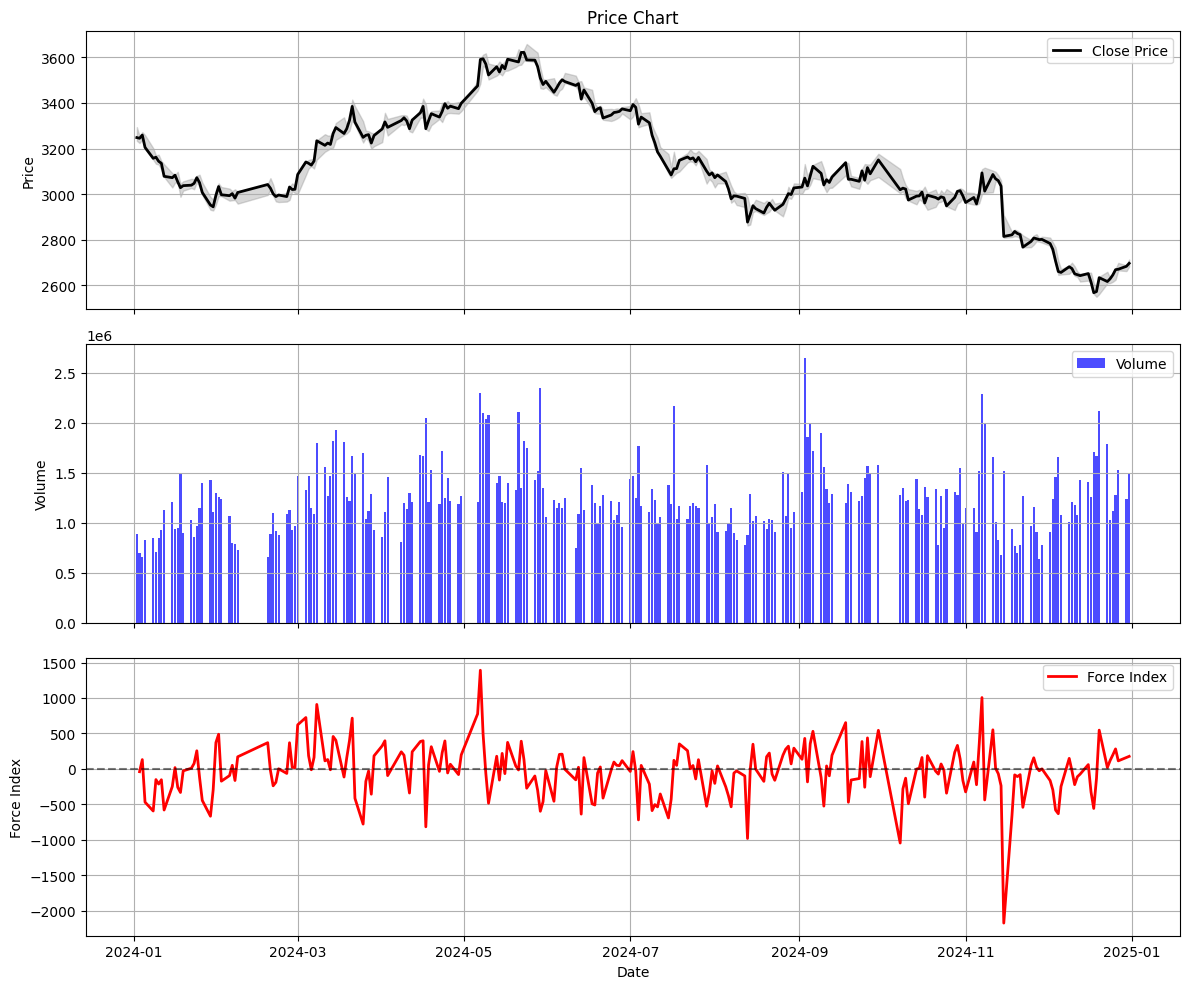

强力指标数值:
2024-01-03: -40.36
2024-01-04: 130.56
2024-01-05: -469.44
2024-01-08: -594.76
2024-01-09: -151.52
2024-01-10: -214.35
2024-01-11: -153.85
2024-01-12: -580.86
2024-01-15: -249.62
2024-01-16: 17.61
2024-01-17: -260.20
2024-01-18: -333.04
2024-01-19: -28.74
2024-01-22: 8.87
2024-01-23: 75.84
2024-01-24: 254.97
2024-01-25: -119.71
2024-01-26: -445.57
2024-01-29: -668.05
2024-01-30: -296.89
2024-01-31: 370.27
2024-02-01: 488.55
2024-02-02: -173.78
2024-02-05: -94.95
2024-02-06: 49.90
2024-02-07: -164.38
2024-02-08: 170.07
2024-02-19: 369.16
2024-02-20: -23.08
2024-02-21: -239.53
2024-02-22: -189.65
2024-02-23: 0.63
2024-02-26: -64.64
2024-02-27: 368.55
2024-02-28: 22.11
2024-02-29: 16.55
2024-03-01: 620.92
2024-03-04: 724.07
2024-03-05: 184.56
2024-03-06: -12.89
2024-03-07: 162.49
2024-03-08: 908.77
2024-03-11: 112.78
2024-03-12: 131.26
2024-03-13: -13.03
2024-03-14: 456.94
2024-03-15: 403.14
2024-03-18: -115.32
2024-03-19: 158.16
2024-03-20: 398.33
2024-03-21: 715.37
2024-03-22: -4

,id,symbol,exchange,name,date,open,high,low,close,volume,open_interest,settlement_price,data_type,created_time,updated_time,price_change,log_volume,raw_force,force_index
0,2217,M0,dce,豆粕连续,2024-01-02,3290.0,3294.0,3234.0,3248.0,884958,1429605,3258.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,NaN,13.693297,NaN,NaN
1,2218,M0,dce,豆粕连续,2024-01-03,3255.0,3255.0,3224.0,3245.0,696827,1403900,3239.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,-3.0,13.454294,-40.362882,-40.362882
2,2219,M0,dce,豆粕连续,2024-01-04,3248.0,3272.0,3240.0,3259.0,656713,1395513,3254.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,14.0,13.395004,187.530054,130.556820
3,2220,M0,dce,豆粕连续,2024-01-05,3254.0,3259.0,3198.0,3205.0,831901,1441603,3226.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,-54.0,13.631470,-736.099376,-469.435931
4,2221,M0,dce,豆粕连续,2024-01-08,3200.0,3202.0,3151.0,3157.0,845592,1434756,3174.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,-48.0,13.647793,-655.094085,-594.755185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2454,M0,dce,豆粕连续,2024-12-25,2630.0,2649.0,2615.0,2645.0,1116068,2557221,2631.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,17.0,13.925323,236.730495,196.830833
238,2455,M0,dce,豆粕连续,2024-12-26,2638.0,2672.0,2624.0,2668.0,1272960,2511561,2649.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,23.0,14.056856,323.307694,281.148740
239,2456,M0,dce,豆粕连续,2024-12-27,2672.0,2698.0,2665.0,2670.0,1528419,2467545,2679.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,2.0,14.239745,28.479490,112.702573
240,2457,M0,dce,豆粕连续,2024-12-30,2671.0,2687.0,2662.0,2683.0,1237240,2442770,2675.0,main_continuous,2025-09-17 09:34:04,2025-10-20 09:23:08,13.0,14.028394,182.369128,159.146943


In [36]:
# 使用手动绘制
plot_manual_force_index(data_df)